In [209]:
import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import scipy.stats as stats
# from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', 40)

In [168]:
con = sqlite3.connect('data/transformed/team_moving_avgs_merged.sqlite')
team_last_20 = pd.read_sql_query(f"SELECT * FROM \"{'team_last_20'}\"", con)
team_last_30 = pd.read_sql_query(f"SELECT * FROM \"{'team_last_30'}\"", con)
team_last_40 = pd.read_sql_query(f"SELECT * FROM \"{'team_last_40'}\"", con)
team_all_season = pd.read_sql_query(f"SELECT * FROM \"{'team_all_season'}\"", con)
con.close()

team_last_20['Date'] = pd.to_datetime(team_last_20['Date'])
team_last_30['Date'] = pd.to_datetime(team_last_30['Date'])
team_last_40['Date'] = pd.to_datetime(team_last_40['Date'])
team_all_season['Date'] = pd.to_datetime(team_all_season['Date'])

team_last_30.columns

Index(['game_id', 'Date', 'Season', 'home_team', 'home_win', 'home_streak',
       'home_last10', 'home_FG', 'home_FGA', 'home_FG%', 'home_3P', 'home_3PA',
       'home_3P%', 'home_FT', 'home_FTA', 'home_FT%', 'home_ORB', 'home_DRB',
       'home_TRB', 'home_AST', 'home_STL', 'home_BLK', 'home_TOV', 'home_PF',
       'home_PTS', 'home_TS%', 'home_eFG%', 'home_3PAr', 'home_FTr',
       'home_ORB%', 'home_DRB%', 'home_TRB%', 'home_AST%', 'home_STL%',
       'home_BLK%', 'home_TOV%', 'home_ORtg', 'home_DRtg', 'home_Pace',
       'away_team', 'away_streak', 'away_last10', 'away_FG', 'away_FGA',
       'away_FG%', 'away_3P', 'away_3PA', 'away_3P%', 'away_FT', 'away_FTA',
       'away_FT%', 'away_ORB', 'away_DRB', 'away_TRB', 'away_AST', 'away_STL',
       'away_BLK', 'away_TOV', 'away_PF', 'away_PTS', 'away_TS%', 'away_eFG%',
       'away_3PAr', 'away_FTr', 'away_ORB%', 'away_DRB%', 'away_TRB%',
       'away_AST%', 'away_STL%', 'away_BLK%', 'away_TOV%', 'away_ORtg',
       'away_DRtg', 'awa

In [205]:
def prepare_data(data):
    data = data.dropna(how='any') #axis=1,

    totals_columns = ['home_FG', 'home_FGA', 'home_FG%', 'home_3P', 'home_3PA',
       'home_3P%', 'home_FT', 'home_FTA', 'home_FT%', 'home_ORB', 'home_DRB',
       'home_TRB', 'home_AST', 'home_STL', 'home_BLK', 'home_TOV', 'home_PF',
       'home_PTS',  'home_TS%', 'away_FG', 'away_FGA',
       'away_FG%', 'away_3P', 'away_3PA', 'away_3P%', 'away_FT', 'away_FTA',
       'away_FT%', 'away_ORB', 'away_DRB', 'away_TRB', 'away_AST', 'away_STL',
       'away_BLK', 'away_TOV', 'away_PF', 'away_PTS', 'away_TS%']

    prc_columns = ['home_TS%', 'home_eFG%', 'home_3PAr', 'home_FTr',
       'home_ORB%', 'home_DRB%', 'home_TRB%', 'home_AST%', 'home_STL%',
       'home_BLK%', 'home_TOV%', 'home_ORtg', 'home_DRtg', 'away_TS%', 'away_eFG%',
       'away_3PAr', 'away_FTr', 'away_ORB%', 'away_DRB%', 'away_TRB%',
       'away_AST%', 'away_STL%', 'away_BLK%', 'away_TOV%', 'away_ORtg',
       'away_DRtg']
    X_train = data[data['Date'] < '2023-10-01']\
        .drop(columns=['game_id', 'Date', 'Season',
                       'home_team', 'home_win',
                       'away_team']) \
        .drop(columns=totals_columns)

    X_test = data[data['Date'] > '2023-10-01']\
        .drop(columns=['game_id', 'Date', 'Season',
                       'home_team', 'home_win',
                       'away_team'])\
        .drop(columns=totals_columns)

    y_train = data[data['Date'] < '2023-10-01'].loc[:,'home_win']
    y_test = data[data['Date'] > '2023-10-01'].loc[:,'home_win']

    # nan_columns_X_train = X_train.columns[X_train.isna().any()].tolist()
    # nan_columns_X_test = X_test.columns[X_test.isna().any()].tolist()
    # print(nan_columns_X_train, nan_columns_X_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_test_pca, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(team_last_30)

In [206]:
model = LogisticRegression(solver='saga', C=0.3,  max_iter=750) # , C=0.3 ok

#rfe = RFE(model)
#X_selected = rfe.fit_transform(X_train, y_train)
model.fit(X_train, y_train)

# X_test_selected = rfe.transform(X_test)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Dokładność modelu: {accuracy * 100:.2f}%")
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred))

Dokładność modelu: 64.49%

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.65      0.49      0.56       530
           1       0.64      0.78      0.70       633

    accuracy                           0.64      1163
   macro avg       0.65      0.63      0.63      1163
weighted avg       0.65      0.64      0.64      1163



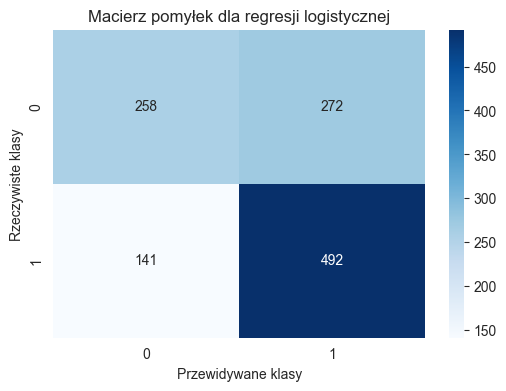

In [207]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Przewidywane klasy")
plt.ylabel("Rzeczywiste klasy")
plt.title("Macierz pomyłek dla regresji logistycznej")
plt.savefig("graphs/confusion_matrix_rl.png", dpi=300, bbox_inches='tight')
plt.show()

In [210]:
with open('Models/LR_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Brak zmienności przy używaniu średnich kroczących z różnym oknem

PCA nie ma wielkiego wpływu na wynik precyzji

63.63% -> 64.49% przy usunieciu zmiennych totals

usunięcie zmiennych procentowych negatywnie wpływa na model -> spadek o 1.5pp w porownaniu do najlepszego modelu - tylko z grupą zmiennych procentowych

pozostawienie grup zarówno procentowych jak i nominalnych jest gorsze niż tylko procentowe, ale lepsze niż pozostawienie tylko nominalnych

1. Precision (Precyzja):
Precyzja to miara dokładności w przewidywaniu pozytywnych przypadków (klasa 1).

Dla klasy 0: Precyzja wynosi 0.64, co oznacza, że spośród wszystkich przypadków, które model zakwalifikował jako 0, 64% rzeczywiście było klasą 0.
Dla klasy 1: Precyzja wynosi 0.64, co oznacza, że spośród wszystkich przypadków, które model zakwalifikował jako 1, 64% rzeczywiście było klasą 1.
2. Recall (Czułość):
Recall to miara zdolności modelu do wychwycenia wszystkich rzeczywistych przypadków danej klasy.

Dla klasy 0: Recall wynosi 0.47, co oznacza, że model poprawnie zidentyfikował 47% rzeczywistych przypadków klasy 0 (spośród wszystkich prawdziwych 0).
Dla klasy 1: Recall wynosi 0.77, co oznacza, że model poprawnie zidentyfikował 77% rzeczywistych przypadków klasy 1.